In [1]:
import sys
import joblib
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoModel
from transformers import AutoTokenizer
from transformers import BartForSequenceClassification
from transformers import BartTokenizer
from torch import nn
from torch.nn import functional as F
from collections import defaultdict

I0805 10:44:53.283748 10168 file_utils.py:39] PyTorch version 1.2.0 available.


In [15]:
df = joblib.load("../data/sp500_top100_v4.bin")
df_1 = df.drop_duplicates(subset="content", inplace=False)
print(df.shape[0] - df_1.shape[0])

56782


In [6]:
df_test = df[df["ticker"] == "MSFT"]
print(df_test.iloc[0]["content"])
print(df_test.iloc[0]["url"])
print("")
print(df_test.iloc[1]["content"])
print(df_test.iloc[1]["url"])

Please double-check the URL for proper spelling, browse our site index, or search Reuters.com using the Search box above.The best of Reuters news delivered right into your email box absolutely free.All the news you need to start your day.Reuters, the news and media division of Thomson Reuters, is the world’s largest international multimedia news provider reaching more than one billion people every day. Reuters provides trusted business, financial, national, and international news to professionals via Thomson Reuters desktops, the world's media organizations, and directly to consumers at Reuters.com and via Reuters TV.  Learn more about Thomson Reuters products:
https://www.reuters.com/article/idUSKBN22V27Z

Please double-check the URL for proper spelling, browse our site index, or search Reuters.com using the Search box above.The best of Reuters news delivered right into your email box absolutely free.All the news you need to start your day.Reuters, the news and media division of Thoms

In [2]:
def progressbar(iter, prefix="", size=60, file=sys.stdout):
    # Reference from https://stackoverflow.com/questions/3160699/python-progress-bar
    count = len(iter)
    def show(t):
        x = int(size*t/count)
        # file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), int(100*t/count), 100))
        file.write("{}[{}{}] {}%\r".format(prefix, "#"*x, "."*(size-x), int(100*t/count)))
        file.flush()
    show(0)
    for i, item in enumerate(iter):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

In [3]:
df = joblib.load("../data/sp500_top100_v2.bin")
df["ps_content_filter"] = df["ps_content"].apply(lambda x: x if len(str(x)) >= 10 else "empty content")
print(df.shape)

(97321, 8)


In [77]:
import nltk
from lexrank import STOPWORDS, LexRank
from path import Path

documents = []
documents_dir = Path('../data/bbc/politics')

for file_path in documents_dir.files('*.txt'):
    with file_path.open(mode='rt', encoding='utf-8') as fp:
        documents.append(fp.readlines())
lxr = LexRank(documents, stopwords=STOPWORDS['en'])

def lxr_score(sentence, lxr):
    
    scores_cont = lxr.rank_sentences(
        nltk.sent_tokenize(sentence),
        threshold=None, 
        fast_power_method=True)
    
    return np.median(scores_cont)

In [78]:
import swifter
import numpy as np
from tqdm.notebook import tqdm

tqdm.pandas()
df["sim"] = df.progress_apply(lambda row: lxr_score(row["ps_content_filter"], lxr), axis=1)

In [84]:
df.head(10)

,title,date,query,url,ticker,content,ps_content,ps_content_filter,sim
0,BRIEF-Apple Inc Says Not Allowing Entertainmen...,2020-03-15,Apple Inc.,https://www.reuters.com/article/idUSFWN2B61K2,AAPL,March 14 (Reuters) - Apple Inc: * APPLE INC SA...,,empty content,1.0
1,Apple signs multi-year deals with major music ...,2020-03-12,Apple Inc.,https://www.reuters.com/article/idUSKBN20Z33J,AAPL,(Reuters) - Apple Inc has sealed multi-year li...,(Reuters) - Apple Inc has sealed multi-year li...,(Reuters) - Apple Inc has sealed multi-year li...,1.0
2,Apple signs multi-year deals with major music ...,2020-03-12,Apple Inc.,https://www.reuters.com/article/idUSL4N2B54T2,AAPL,(Reuters) - Apple Inc has sealed multi-year li...,NaN,empty content,1.0
3,Chinese regulators remove 'Plague Inc' game fr...,2020-02-28,Apple Inc.,https://www.reuters.com/article/idUSKCN20M043,AAPL,BEIJING/SHANGHAI (Reuters) - The video game “P...,The regulator did not respond to Reuters phone...,The regulator did not respond to Reuters phone...,1.0
4,UPDATE 1-Chinese regulators remove 'Plague Inc...,2020-02-28,Apple Inc.,https://www.reuters.com/article/idUSL3N2AS0OO,AAPL,BEIJING/SHANGHAI (Reuters) - The video game “P...,NaN,empty content,1.0
5,Apple launches new MacBook Pro,2020-05-04,Apple Inc.,https://www.reuters.com/article/idUSL4N2CM29Z,AAPL,May 4 (Reuters) - Apple Inc on Monday launched...,Apple said here its new lineup of MacBook Pro ...,Apple said here its new lineup of MacBook Pro ...,1.0
6,Broadcom to supply wireless components to Apple,2020-01-23,Apple Inc.,https://www.reuters.com/article/idUSKBN1ZM32H,AAPL,(Reuters) - Chipmaker Broadcom Inc (AVGO.O) sa...,(Reuters) - Chipmaker Broadcom Inc (AVGO.O) sa...,(Reuters) - Chipmaker Broadcom Inc (AVGO.O) sa...,1.0
7,Apple expands services business to markets in ...,2020-04-21,Apple Inc.,https://www.reuters.com/article/idUSL1N2C900N,AAPL,(Reuters) - Apple Inc (AAPL.O) on Tuesday said...,(Reuters) - Apple Inc (AAPL.O) on Tuesday said...,(Reuters) - Apple Inc (AAPL.O) on Tuesday said...,1.0
8,"Factbox: How to watch Apple TV+, Apple's entry...",2019-11-01,Apple Inc.,https://www.reuters.com/article/idUSKBN1XB3TM,AAPL,LOS ANGELES (Reuters) - Apple Inc (AAPL.O) unv...,The offering will be free for a year for anyon...,The offering will be free for a year for anyon...,1.0
9,Apple to expand operations in India - IT minister,2019-11-25,Apple Inc.,https://www.reuters.com/article/idUSL4N2852IX,AAPL,"NEW DELHI, Nov 25 (Reuters) - India’s informat...","NEW DELHI, Nov 25 (Reuters) - India’s informat...","NEW DELHI, Nov 25 (Reuters) - India’s informat...",1.0


In [85]:
def transform_df(df, by, sort_by, k=10):
    """
    Transform dataframe into another dataframe with top k news using zero-shot learner.
    :param df: pandas dataframe
    :param sort_by: str
    :param k: int
    :return: pandas dataframe
    """
    # Group tweets by date and aggregate into a list
    df_temp = df.copy()
    df_temp["date"] = pd.to_datetime(df_temp["date"], utc=True)
    df_temp['date'] = df_temp['date'].apply(lambda x: x.date())
    df_temp = df_temp.sort_values(['date', sort_by], ascending=False).groupby('date').head(100)
    df_temp = df_temp.groupby("date")[by].agg(list)
    df_temp = df_temp.reset_index(drop=False, inplace=False)
    df_temp.columns = ["date", "agg_news"]

    # Create top k tweet columns
    new_cols = ["Top {} News".format(i + 1) for i in range(k)]
    df_temp = df_temp.assign(**dict.fromkeys(new_cols, np.NaN))

    # Update every columns
    print("Start transforming dataframe...")
    for index, row in df_temp.iterrows():
        try:
            i = 1
            for news in row["agg_news"]:
                column = "Top {} News".format(i)
                df_temp.loc[index, column] = news
                i += 1
                if i > k:
                    break
        except:
            pass
    df = df_temp.drop("agg_news", axis=1)
    print("Done!")

    return df

In [86]:
df_test = transform_df(df, by="ps_content_filter", sort_by="sim", k=25)

Start transforming dataframe...
Done!


In [87]:
df_test.head()

,date,Top 1 News,Top 2 News,Top 3 News,Top 4 News,Top 5 News,Top 6 News,Top 7 News,Top 8 News,Top 9 News,...,Top 16 News,Top 17 News,Top 18 News,Top 19 News,Top 20 News,Top 21 News,Top 22 News,Top 23 News,Top 24 News,Top 25 News
0,2011-08-23,Romney says he needs a bigger place to have ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-08-29,Bank of America Corp is selling about half its...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-09-02,"Reuters provides trusted business, financial, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-09-06,"Reuters provides trusted business, financial, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-09-08,"Reuters provides trusted business, financial, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
df_test.tail()

,date,Top 1 News,Top 2 News,Top 3 News,Top 4 News,Top 5 News,Top 6 News,Top 7 News,Top 8 News,Top 9 News,...,Top 16 News,Top 17 News,Top 18 News,Top 19 News,Top 20 News,Top 21 News,Top 22 News,Top 23 News,Top 24 News,Top 25 News
3086,2020-07-16,July 16 (Reuters) - Canada’s main stock index ...,(Reuters) - Apple Inc said on Thursday it was ...,empty content,"Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...",...,"Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ..."
3087,2020-07-17,"Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...",...,"Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ..."
3088,2020-07-18,"Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...",empty content,empty content,(Reuters) - The S&P 500 ended higher on Friday...,empty content,"Reuters provides trusted business, financial, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3089,2020-07-19,"Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...",Small-cap stocks are often considered a barome...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3090,2020-07-20,"Reuters provides trusted business, financial, ...",VIENNA (Reuters) - Austrian chipmaker AT&S (AT...,empty content,"Last month, Tengku Zafrul said even compensati...",empty content,empty content,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


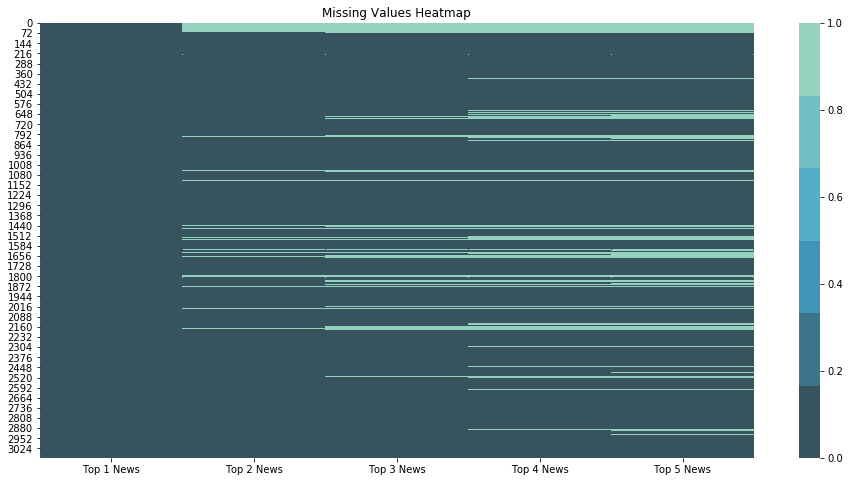

In [97]:
plt.figure(figsize=(16, 8))
sns.heatmap(df_test.iloc[:, 1:6].isnull(), cbar=True, cmap=sns.color_palette("GnBu_d"))
plt.title("Missing Values Heatmap")
plt.show()

In [100]:
joblib.dump(df, "../data/sp500_top100_v4.bin", compress=5)

['../data/sp500_top100_v4.bin']